In [1]:
from IPython.display import clear_output
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16
clear_output()

In [2]:
import cv2
import numpy as np
import os
from pathlib import Path
import glob
# import string
import matplotlib.pyplot as plt
# import random
from tqdm import tqdm 
# from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.svm import LinearSVC
%matplotlib inline

In [3]:
cv2.__version__

'3.4.2'

## 1. Data preprocessing

#### Download dataset

In [4]:
!git clone "https://github.com/Horea94/Fruit-Images-Dataset.git" "/tmp/input"

fatal: destination path '/tmp/input' already exists and is not an empty directory.


#### Split dataset

In [5]:
def getYourFruits(fruits, data_split, print_n=False, k_fold=False):
    images = []
    labels = []
    val = ['Training', 'Test']

    path = Path("/tmp/input/") / data_split
    if print_n: 
      print(f'\nThere are {len(os.listdir(path))} classes in {path}')

    for i, fruit in enumerate(fruits):
        p = path / fruit
        j=0
        for image_path in p.glob("*.jpg"):
            image = cv2.imread(str(image_path), cv2.IMREAD_COLOR)
            image = cv2.resize(image, (dim, dim))
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            images.append(image)
            labels.append(i)
            j+=1
        if(print_n):
            print(f"There are {j} {data_split.upper()} images of {fruits[i].upper()}")
    images = np.array(images)
    labels = np.array(labels)
    return images, labels
    
def getAllFruits():
    fruits = []
    for fruit_path in glob.glob("/tmp/input/Training/*"):
        fruit = fruit_path.split("/")[-1]
        fruits.append(fruit)
    return fruits

#### Visualize dataset

In [6]:
def plot_image_grid(images, text, nb_rows, nb_cols, figsize=(15, 15)):
    assert len(images) == nb_rows*nb_cols, "Number of images should be the same as (nb_rows*nb_cols)"
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].axis('off')
            axs[i, j].title.set_text(text[n])
            axs[i, j].imshow(images[n])
            n += 1        

## 2. SIFT-BOVW pipeline

In [7]:
def computeFeatures(extractor, images):
  keypoints = []
  descriptors = []
  des_imgs = []
  for img in tqdm(images):
    kp, des = extractor.detectAndCompute(img, None)

    keypoints.append(kp)
    des_imgs.append(des)
    
    if des is not None:
      for d in des:
        descriptors.append(d)

  return np.array(keypoints), np.array(descriptors), np.array(des_imgs)

## 3. Classification of feature-vectors

In [8]:
def clustering(k, labels, descriptors):
  batch_size = int(len(labels) / 5)
  kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, verbose=1, random_state=0)
  kmeans = kmeans.fit(descriptors)
  return kmeans

In [18]:
def histograms(k, clusters, kps, image_des):
  clusters.verbose = False

  histo_list = []
  
  for iter in tqdm(range(image_des.shape[0])):
      histo = np.zeros(k)
      nkp = np.size(kps[i])

      for d in image_des[i]:
          idx = clusters.predict([d])
          histo[idx] += 1/nkp 

      histo_list.append(histo)
    
  return np.array(histo_list)

## 4. Hyperparameters tuning

In [10]:
def fit(model, X, Y):
  model.fit(X, Y)
  return model

In [11]:
def predict(model, images, clusters, extractor):
  preds = []
  y = []
  for img in images:
      kp, des = extractor.detectAndCompute(img, None)

      x = np.zeros(k)
      nkp = np.size(kp)

      if des is not None:
        for d in des:
            idx = clusters.predict([d])
            x[idx] += 1/nkp

        y.append(x)
        res = model.predict_proba([x])
        preds.append(np.argmax(res))

  return preds, y

# 5. Results

In [12]:
# Example for multiclass classification on all the training data
dim = 100 #image height, width
fruits = getAllFruits() 

#Get Images and Labels 
X_train_img, y_train =  getYourFruits(fruits, 'Training', print_n=False, k_fold=False)
X_test_img, y_test = getYourFruits(fruits, 'Test', print_n=False, k_fold=False)

In [13]:
print(X_train_img.shape)
print(X_test_img.shape)

(67692, 100, 100, 3)
(22688, 100, 100, 3)


In [14]:
sift = cv2.xfeatures2d.SIFT_create()
surf = cv2.xfeatures2d.SURF_create()

keypoints_surf, descriptors_surf, des_imgs_surf = computeFeatures(surf, X_train_img)
keypoints_sift, descriptors_sift, des_imgs_sift = computeFeatures(sift, X_train_img)
print(descriptors_surf.shape)

100%|██████████| 67692/67692 [06:05<00:00, 185.25it/s]


(1878630, 64)


SIFT
SURF


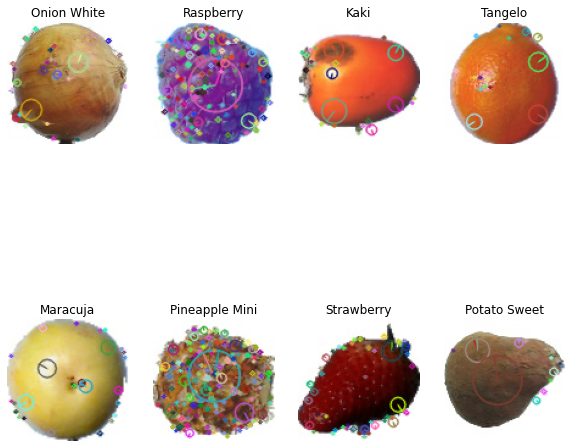

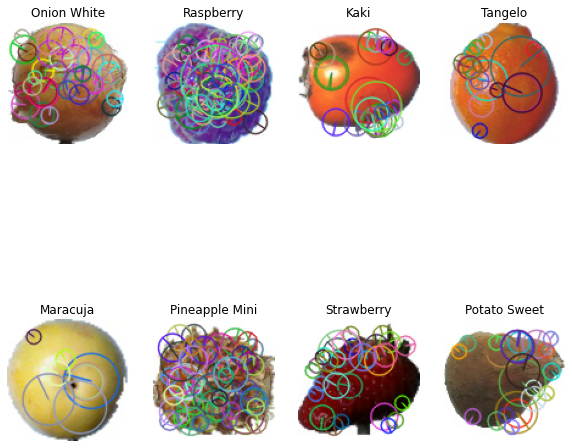

In [15]:
inds = [0, 4002, 5006, 7500, 10000, 15000, 25600, 35000]
ncol, nrows = 2, 4
text = [fruits[y_train[i]] for i in inds]

print("SIFT")
drawImg = []

for i in inds:
  drawImg.append(cv2.drawKeypoints(X_train_img[i], keypoints_sift[i], 
                      None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

plot_image_grid(drawImg, text, ncol, nrows, figsize=(10, 10))

print('SURF')
drawImg = []

for i in inds:
  drawImg.append(cv2.drawKeypoints(X_train_img[i], keypoints_surf[i], 
                      None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

plot_image_grid(drawImg, text, ncol, nrows, figsize=(10, 10))

In [16]:
k = len(fruits) * 10

kmeans_sift = clustering(k, fruits, descriptors_sift)
kmeans_surf = clustering(k, fruits, descriptors_surf)

Init 1/3 with method: k-means++


/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:1576: RuntimeWarning: init_size=78 should be larger than k=1310. Setting it to 3*k
  init_size=init_size)


Inertia for init 1/3: 224365.828125
Init 2/3 with method: k-means++


/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:1576: RuntimeWarning: init_size=78 should be larger than k=1310. Setting it to 3*k
  init_size=init_size)


Inertia for init 2/3: 194153.328125
Init 3/3 with method: k-means++


/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:1576: RuntimeWarning: init_size=78 should be larger than k=1310. Setting it to 3*k
  init_size=init_size)


Inertia for init 3/3: 287504.250000
Minibatch iteration 1/9593100: mean batch inertia: 52432.581731, ewa inertia: 52432.581731 
Minibatch iteration 2/9593100: mean batch inertia: 54063.596154, ewa inertia: 52432.615735 
Minibatch iteration 3/9593100: mean batch inertia: 70924.302885, ewa inertia: 52433.001258 
Minibatch iteration 4/9593100: mean batch inertia: 60358.096154, ewa inertia: 52433.166484 
Minibatch iteration 5/9593100: mean batch inertia: 55862.961538, ewa inertia: 52433.237990 
Minibatch iteration 6/9593100: mean batch inertia: 50639.913462, ewa inertia: 52433.200602 
Minibatch iteration 7/9593100: mean batch inertia: 60451.951923, ewa inertia: 52433.367781 
Minibatch iteration 8/9593100: mean batch inertia: 53116.600962, ewa inertia: 52433.382025 
Minibatch iteration 9/9593100: mean batch inertia: 61048.341346, ewa inertia: 52433.561634 
[MiniBatchKMeans] Reassigning 13 cluster centers.
Minibatch iteration 10/9593100: mean batch inertia: 56470.543269, ewa inertia: 52433.6

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:1576: RuntimeWarning: init_size=78 should be larger than k=1310. Setting it to 3*k
  init_size=init_size)


Inertia for init 1/3: 0.221479
Init 2/3 with method: k-means++


/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:1576: RuntimeWarning: init_size=78 should be larger than k=1310. Setting it to 3*k
  init_size=init_size)


Inertia for init 2/3: 0.409663
Init 3/3 with method: k-means++


/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:1576: RuntimeWarning: init_size=78 should be larger than k=1310. Setting it to 3*k
  init_size=init_size)


Inertia for init 3/3: 0.227428
Minibatch iteration 1/7225500: mean batch inertia: 0.070685, ewa inertia: 0.070685 
Minibatch iteration 2/7225500: mean batch inertia: 0.086286, ewa inertia: 0.070686 
Minibatch iteration 3/7225500: mean batch inertia: 0.084384, ewa inertia: 0.070686 
Minibatch iteration 4/7225500: mean batch inertia: 0.066455, ewa inertia: 0.070686 
Minibatch iteration 5/7225500: mean batch inertia: 0.076677, ewa inertia: 0.070686 
Minibatch iteration 6/7225500: mean batch inertia: 0.068639, ewa inertia: 0.070686 
Minibatch iteration 7/7225500: mean batch inertia: 0.093620, ewa inertia: 0.070687 
Minibatch iteration 8/7225500: mean batch inertia: 0.069361, ewa inertia: 0.070687 
Minibatch iteration 9/7225500: mean batch inertia: 0.087553, ewa inertia: 0.070687 
[MiniBatchKMeans] Reassigning 13 cluster centers.
Minibatch iteration 10/7225500: mean batch inertia: 0.072735, ewa inertia: 0.070687 
Minibatch iteration 11/7225500: mean batch inertia: 0.064942, ewa inertia: 0.0

In [20]:
histo_list_sift = histograms(k,  kmeans_sift, keypoints_sift, des_imgs_sift)
histo_list_surf  = histograms(k, kmeans_surf, keypoints_surf, des_imgs_surf)

Streaming output truncated to the last 5000 lines.
 76%|███████▌  | 51363/67692 [25:33<07:32, 36.11it/s]

KeyboardInterrupt: ignored

In [ ]:
clf = LinearSVC(max_iter=80000)
mlp = MLPClassifier(verbose=False, max_iter=600000)

mlp_sift = fit(mlp, histo_list_sift, y_train)
mlp_surf = fit(mlp, histo_list_surf, y_train)
clf_sift = fit(clf, histo_list_sift, y_train)
clf_surf = fit(clf, histo_list_surf, y_train)

In [ ]:
y_pred_mlp_sift, y_mlp_sift = predict(mlp_sift, X_test_img, kmeans_sift, sift)
y_pred_mlp_surf, y_mlp_surf = predict(mlp_surf, X_test_img, kmeans_surf, surf)
y_pred_clf_sift, y_clf_sift = predict(clf_sift, X_test_img, kmeans_sift, sift)
y_pred_clf_surf, y_clf_surf = predict(clf_surf, X_test_img, kmeans_surf, surf)

predicted = [y_pred_mlp_sift, y_pred_mlp_surf, y_pred_clf_sift, y_pred_clf_surf]
methods = ["MLP sift", "MLP surf", "SVM sift", "SVM surf"]

In [ ]:
for i in range(len(predicted)):
  print(f"Accuracy {methods[i]}: {accuracy_score(y_test, predicted[i])}")

In [ ]:
for i in range(len(predicted)):
  y_pred = predicted[i]
  print(f"F1 score macro {methods[i]}: {f1_score(y_test, y_pred, average='macro')}")
  print(f"F1 score micro {methods[i]}: {f1_score(y_test, y_pred, average='micro')}")
  print(f"F1 score weighted {methods[i]}: {f1_score(y_test, y_pred, average='weighted')}")

In [ ]:
inds = [1, 1050, 6560, 9550, 12000, 15000, 18500, 21000]
nrows = 2
ncol = 4

imgs = []
text = []
for i in inds:
  text.append(f"Pred: {fruits[y_pred[i]]}, True: {fruits[y_test[i]]}")
  imgs.append(X_test_img[i])

plot_image_grid(imgs, text, nrows, ncol, figsize=(10, 10))

## References

https://www.kaggle.com/waltermaffy/fruit-classification-pca-svm-knn-decision-tree